In [1]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from collections import Counter, defaultdict
import json, csv
import numpy as np
import xmltodict
from sklearn.dummy import DummyClassifier
import random
import os
from statistics import mean, stdev
import warnings 
from scipy.stats import ttest_rel, levene
from collections import defaultdict
from typing import List, Dict, Tuple
from scipy import stats
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from rouge_score import rouge_scorer

warnings.filterwarnings('ignore') 

Task 1, Gemini1.5-5s (strongest) -- FP and FN

In [2]:
def get_kshot_examples(dataset, shots, split):
    """Get k-shot examples for a specific dataset, shot count and split."""
    if shots == "0":
        return []
    
    dataset_name = dataset.upper()
    shots_name = f"{shots}shot"
    
    filename = f"/Users/guida/llm_argument_tasks/run_all_k_shots/k-shots/{dataset_name}_all_arguments_main_{shots_name}_split_{split}.csv"
    filepath = os.path.join("run_all_k_shots", "k-shots", filename)
    
    df = pd.read_csv(filepath)
    return df['id'].tolist()

In [3]:
def get_gold(binarize, task, data, kshot_examples, data_dir='/Users/guida/llm_argument_tasks/clean_data/'):
    data = open(f'{data_dir}{data.upper()}.xml', 'r').read()
    data = xmltodict.parse(data)
    
    gold = {}
    # binary labels (3 => 0; all else => 1)
    if task == 1:
        for comarg in data['document']['unit']:
            ii = comarg['@id']
            label = comarg['label']
            if label == '3' and ii not in kshot_examples:
                gold[ii] = 0
            elif ii not in kshot_examples:
                gold[ii] = 1
                
    # types of use
    # binary: 4/5 = 5 and 1/2 = 1 and 3 = delete
    # 4-way: 1, 2, 4, 5, 3 = delete
    if task == 2:
        for comarg in data['document']['unit']:
            ii = comarg['@id']
            label = comarg['label']
            if binarize:
                if label in ['1','2']:
                    label = 1
                elif label in ['4','5']:
                    label = 5
            if label != '3' and ii not in kshot_examples:
                gold[ii] = int(label)
    return gold

In [4]:
def get_predictions(fname, gold): 
    preds = pd.read_json(fname, lines=True).to_dict()
    preds = {preds['id'][i]: preds['label'][i] for i in preds['id'].keys()}
   
    gold_list = []
    pred_list = []
    ids = []

    gold_ids = set(gold.keys())
    pred_ids = set(preds.keys())
    
   # print(f"Gold IDs count: {len(gold_ids)}, Prediction IDs count: {len(pred_ids)}")
   # print(f"Overlap count: {len(gold_ids.intersection(pred_ids))}")
   # print(f"Gold-only IDs: {len(gold_ids - pred_ids)}, Pred-only IDs: {len(pred_ids - gold_ids)}")


    for k in set(list(gold.keys()) + list(preds.keys())):
        if k in gold and k in preds:
            ids.append(k)
            gold_list.append(gold[k])
            pred_list.append(preds[k])

    return gold_list, pred_list, ids

def evaluate(gold, predicted):
    prec = precision_score(gold, predicted, average='macro', zero_division=0.0)
    rec = recall_score(gold, predicted, average='macro', zero_division=0.0)
    f1 = (2 * prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0
    support = len(gold)
    cm = confusion_matrix(gold, predicted)
    return prec, rec, f1, support, cm

In [5]:
def evaluate_all_splits():
    results = []
    base_path = "comarg-task1"

    for model in ["gemini"]:
        dataset_results = []
        print(f"\n===== {model} =====")

        for dataset in ["gm", "ugip"]:  
            print(f"\nDataset: {dataset}")
            
            for split in range(1, 6): 
                print(f"\nSplit {split}")

                for shot in ["5"]:
                    kshot_examples = get_kshot_examples(dataset, shot, split)
                    gold_raw = get_gold(binarize=False, task=1, data=dataset, kshot_examples=kshot_examples)
                    pred_file = f"comarg_{dataset}_identification_{model}_{shot}shot_split_{split}.jsonl"
                    pred_path = os.path.join(base_path, model, f"Split{split}", f"{shot}-s", pred_file)

                    try:
                        gold, pred, ids = get_predictions(pred_path, gold_raw)
                        labels = np.unique(np.concatenate([gold, pred]))

                        pr, re, f1, supp, cm = evaluate(gold, pred)
                        result = {
                            'dataset': dataset,
                            'model': model,
                            'split': split,
                            'shot': shot,
                            'precision': pr,
                            'recall': re,
                            'f1': f1,
                            'support': supp
                        }
                        results.append(result)
                        dataset_results.append(result)
                        
                        print(f"{shot}-shot\t", 
                              f"P: {pr:.2f}", 
                              f"R: {re:.2f}", 
                              f"F1: {f1:.2f}", 
                              f"Support: {supp}")
                        
                    except FileNotFoundError:
                        print(f"Missing file: {pred_path}")
                    except Exception as e:
                        print(f"Error processing {pred_path}: {str(e)}")
            

        print(f"\n{'='*20} Aggregate Results for {model} {'='*20}")
        dataset_df = pd.DataFrame(dataset_results)
        agg_results = dataset_df.groupby(['model', 'shot']).agg({
            'precision': ['mean', 'std'],
            'recall': ['mean', 'std'],
            'f1': ['mean', 'std']
        }).round(3)
        
        print(agg_results)
        
    return agg_results

In [89]:
def get_full_argument_context(dataset, unit_id):
    data_dir = '/Users/guida/llm_argument_tasks/clean_data/'
    data = open(f'{data_dir}{dataset.upper()}.xml', 'r').read()

    data = xmltodict.parse(data)
    
    for unit in data['document']['unit']:
        if unit['@id'] == unit_id:
            return {
                'argument': unit['argument']['text'],
                'stance': unit['argument']['stance'],
                'comment': unit['comment']['text']
            }
    return None

def evaluate_all_splits_with_errors():
    results = []
    error_cases = []  # To store information about errors
    base_path = "comarg-task1"

    for model in ["gemini"]:
        dataset_results = []
        print(f"\n===== {model} =====")

        for dataset in ["gm", "ugip"]:  
           #print(f"\nDataset: {dataset}")
            
            for split in range(1, 6): 
               # print(f"\nSplit {split}")

                for shot in ["5"]:
                    kshot_examples = get_kshot_examples(dataset, shot, split)
                    gold_raw = get_gold(binarize=False, task=1, data=dataset, kshot_examples=kshot_examples)
                    pred_file = f"comarg_{dataset}_identification_{model}_{shot}shot_split_{split}.jsonl"
                    pred_path = os.path.join(base_path, model, f"Split{split}", f"{shot}-s", pred_file)

                    try:
                        gold, pred, ids = get_predictions(pred_path, gold_raw)
                        labels = np.unique(np.concatenate([gold, pred]))

                        pr, re, f1, supp, cm = evaluate(gold, pred)
                        result = {
                            'dataset': dataset,
                            'model': model,
                            'split': split,
                            'shot': shot,
                            'precision': pr,
                            'recall': re,
                            'f1': f1,
                            'support': supp,
                            'confusion_matrix': cm
                        }
                        results.append(result)
                        dataset_results.append(result)

                        
                        # Collect errors with full context
                        for i, (g, p, id_) in enumerate(zip(gold, pred, ids)):
                            if g != p:
                                context = get_full_argument_context(dataset, id_)
                                error_cases.append({
                                    'dataset': dataset,
                                    'split': split,
                                    'id': id_,
                                    'gold': g,
                                    'pred': p,
                                    'error_type': 'FP' if p == 1 and g == 0 else 'FN',
                                    'argument': context['argument'],
                                    'stance': context['stance'],# Add argument text
                                    'comment': context['comment']    # Add comment text
                                })
                        
                    except FileNotFoundError:
                        print(f"Missing file: {pred_path}")
                    except Exception as e:
                        print(f"Error processing {pred_path}: {str(e)}")
            
        print(f"\n{'='*20} Aggregate Results for {model} {'='*20}")
        dataset_df = pd.DataFrame(dataset_results)

        agg_results = dataset_df.groupby(['model', 'shot']).agg({
            'precision': ['mean', 'std'],
            'recall': ['mean', 'std'],
            'f1': ['mean', 'std']
        }).round(3)
        
        print(agg_results)
    return agg_results, pd.DataFrame(error_cases)

agg_results, error_comarg = evaluate_all_splits_with_errors()


===== gemini =====

==================== Aggregate Results for gemini ====================
            precision        recall            f1       
                 mean    std   mean    std   mean    std
model  shot                                             
gemini 5        0.795  0.041  0.748  0.027  0.771  0.033


In [91]:
agg_results

precision        recall            f1       
                 mean    std   mean    std   mean    std
model  shot                                             
gemini 5        0.795  0.041  0.748  0.027  0.771  0.033

In [7]:
# 1. Basic error statistics
print("\nError Type Distribution:")
print(error_comarg['error_type'].value_counts())

# 2. Error distribution by dataset
print("\nError Distribution by Dataset:")
print(error_comarg.groupby(['dataset', 'error_type']).size())

# 3. Error distribution by split
print("\nError Distribution by Split:")
print(error_comarg.groupby(['split', 'error_type']).size())


Error Type Distribution:
error_type
FN    1563
FP     621
Name: count, dtype: int64

Error Distribution by Dataset:
dataset  error_type
gm       FN            861
         FP            254
ugip     FN            702
         FP            367
dtype: int64

Error Distribution by Split:
split  error_type
1      FN            302
       FP            116
2      FN            316
       FP            147
3      FN            309
       FP             95
4      FN            317
       FP            117
5      FN            319
       FP            146
dtype: int64


In [8]:
def get_full_argument_context(dataset, unit_id):
    data_dir = '/Users/guida/llm_argument_tasks/clean_data/'
    data = open(f'{data_dir}{dataset.upper()}.xml', 'r').read()
    data = xmltodict.parse(data)
    
    for unit in data['document']['unit']:
        if unit['@id'] == unit_id:
            return {
                'argument': unit['argument']['text'],
                'comment': unit['comment']['text']
            }
    return None
print("\n=== COMPLETE ERROR ANALYSIS ===")

def print_error_case(row):
    data = get_full_argument_context(row['dataset'], row['id'])
    print(f"\nID: {row['id']} | Dataset: {row['dataset']} | Split: {row['split']}")
    print(f"Gold: {row['gold']} | Predicted: {row['pred']} | Error: {row['error_type']}")
    print("\nARGUMENT BEING CLASSIFIED:")
    print(data['argument'])
    print("\nFULL COMMENT CONTEXT:")
    print(data['comment'])
    print("\n" + "="*100)

# False Positives
print("\n=== FALSE POSITIVES (Model incorrectly predicted support) ===")
for _, row in error_comarg[error_comarg['error_type'] == 'FP'].sample(5).iterrows():
    print_error_case(row)

# False Negatives
print("\n=== FALSE NEGATIVES (Model missed actual support) ===")
for _, row in error_comarg[error_comarg['error_type'] == 'FN'].sample(5).iterrows():
    print_error_case(row)


=== COMPLETE ERROR ANALYSIS ===

=== FALSE POSITIVES (Model incorrectly predicted support) ===

ID: 2arg4 | Dataset: gm | Split: 4
Gold: 0 | Predicted: 1 | Error: FP

ARGUMENT BEING CLASSIFIED:
It is discriminatory to refuse gay couples the right to marry

FULL COMMENT CONTEXT:
In answer to It is wrong to create fatherless or motherless families by design. Same-sex marriages have more to do with the desires of adults than the needs of children. Human experience and a vast body of social science research show that children do best in married, mother-father households..Bologna!!There is no solid evidence saying that gay couples put children in an unstable environment children need love and acceptance it doesn't matter what your sexual orientation is if you are capable of being responsible and compassionate- there are many good married Christian parents who abuse and shame their children- Children need positive role models not intolerance and a morality that picks and chooses what's righ

In [9]:
# Look at systematically missclassified error

from collections import Counter

# Get all error cases with their argument texts
error_comarg['argument_text'] = error_comarg.apply(
    lambda row: get_full_argument_context(row['dataset'], row['id'])['argument'],
    axis=1
)

# Count how often each argument text is misclassified
argument_error_counts = Counter(error_comarg['argument_text'])

# Top 10 most frequently misclassified arguments
print("\nTop 10 Systematic Misclassifications:")
for arg_text, count in argument_error_counts.most_common(10):
    print(f"\nCount: {count}")
    print(f"Argument: {arg_text}")
    
    # Get examples of errors for this argument
    examples = error_comarg[error_comarg['argument_text'] == arg_text].head(2)
    for _, ex in examples.iterrows():
        print(f"\nDataset: {ex['dataset']} | Split: {ex['split']}")
        print(f"Error Type: {ex['error_type']}")
        print(f"Full Context: {get_full_argument_context(ex['dataset'], ex['id'])['comment'][:200]}...")


Top 10 Systematic Misclassifications:

Count: 387
Argument: Marriage should be between a man and a woman

Dataset: gm | Split: 1
Error Type: FN
Full Context: There isnt anything wrong with being gay it isnt a choice its what you truly are noyone will force anyone to be gay. Most of the time people become gay due to rape or bullying which is something that ...

Dataset: gm | Split: 1
Error Type: FN
Full Context: Gay marriage should be legal because love is love.  I am Christian and I know that apparently it says something in the bible about no gay marriage. But how are we going to base our life off of a book ...

Count: 240
Argument: America is based on democracy and the pledge should reflect the belief of the American majority.

Dataset: ugip | Split: 1
Error Type: FN
Full Context: This country was founded upon principles of free conscience. Citizens of the United States have the full right to support whichever philosophies they desire, even if these philosophies espouse atheism...

D

<Figure size 1200x800 with 0 Axes>

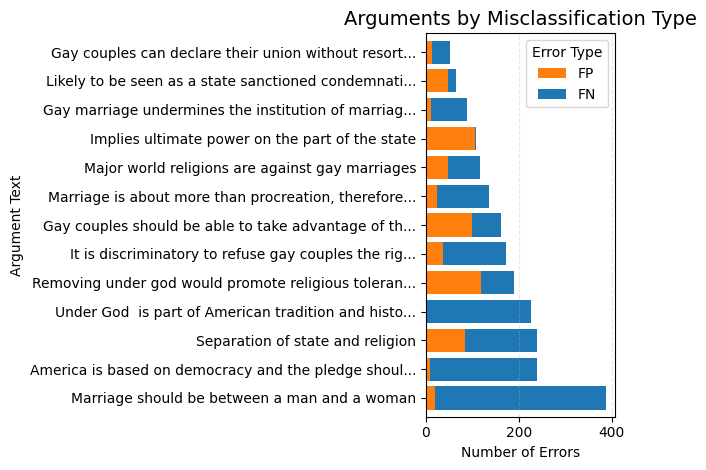

In [10]:
# Prepare the data
error_comarg['argument_text'] = error_comarg.apply(
    lambda row: get_full_argument_context(row['dataset'], row['id'])['argument'],
    axis=1
)

# Get top 15 most frequent arguments in errors
top_arguments = error_comarg['argument_text'].value_counts().index

# Filter and count errors per argument type
plot_data = error_comarg[error_comarg['argument_text'].isin(top_arguments)]
error_counts = plot_data.groupby(['argument_text', 'error_type']).size().unstack().fillna(0)

# Sort by total errors
error_counts['total'] = error_counts.sum(axis=1)
error_counts = error_counts.sort_values('total', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
ax = error_counts[['FP', 'FN']].plot(kind='barh', stacked=True, 
                                   color=['#ff7f0e', '#1f77b4'],
                                   width=0.8)

plt.title('Arguments by Misclassification Type', fontsize=14)
plt.xlabel('Number of Errors')
plt.ylabel('Argument Text')
plt.legend(title='Error Type')

# Truncate long argument texts
ax.set_yticklabels([text[:50] + '...' if len(text) > 50 else text 
                   for text in error_counts.index])

plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

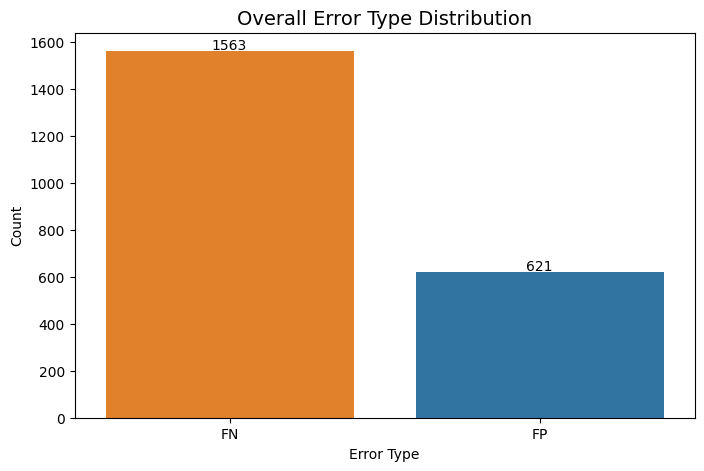

In [11]:
error_counts = error_comarg['error_type'].value_counts()

# Create plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=error_counts.index, y=error_counts.values, palette=['#ff7f0e', '#1f77b4'])

plt.title('Overall Error Type Distribution', fontsize=14)
plt.xlabel('Error Type')
plt.ylabel('Count')

# Add value labels
for i, v in enumerate(error_counts.values):
    ax.text(i, v + 5, str(v), ha='center')

plt.show()

<Figure size 1000x600 with 0 Axes>

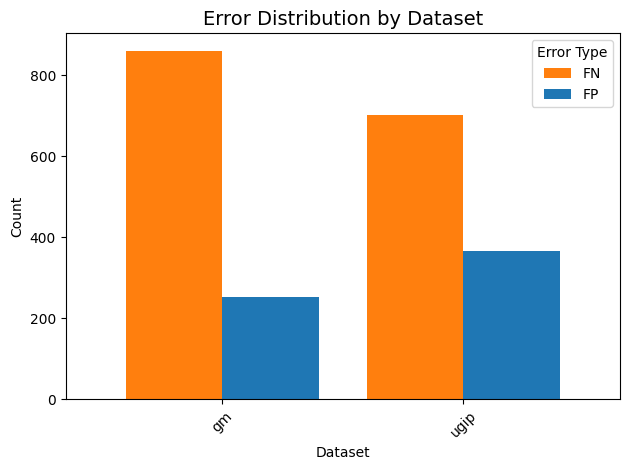

In [12]:
dataset_errors = error_comarg.groupby(['dataset', 'error_type']).size().unstack()

# Create plot
plt.figure(figsize=(10, 6))
dataset_errors.plot(kind='bar', stacked=False, color=['#ff7f0e', '#1f77b4'], width=0.8)

plt.title('Error Distribution by Dataset', fontsize=14)
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Error Type')

plt.tight_layout()
plt.show()

Task 1 YRU

In [13]:
def get_shot_examples(topic, n_shot, split):
    if n_shot not in ["1", "5"]:
        return []
    
    shot_file = f'/Users/guida/llm_argument_tasks/run_all_k_shots/k-shots/yru_{topic}_with_negatives_main_{n_shot}shot_split_{split}.csv'
    try:
        shot_df = pd.read_csv(shot_file)
        return shot_df['uid'].tolist()
    except FileNotFoundError:
        print(f"Warning: Shot file not found: {shot_file}")
        return []

def get_yru_gold(task, shot=None, split=None):
    data = pd.read_csv(f'task1_yru_gold/yru_{task}_with_negatives_main.csv').to_dict()
    yru_gold = {data['uid'][i]: data['present'][i] for i in data['id'].keys()}
    
    if shot == "0":
        return yru_gold
    if shot in ["1", "5"] and split is not None:
        shot_examples = get_shot_examples(task, shot, split)
        yru_gold = {uid: label for uid, label in yru_gold.items() if uid not in shot_examples}
    
    return yru_gold

def get_predictions(fname, gold): 
    preds = pd.read_json(fname, lines=True).to_dict()
    preds = {preds['id'][i]: preds['label'][i] for i in preds['id'].keys()}
   
    gold_list = []
    pred_list = []
    ids = []

    for k in set(list(gold.keys()) + list(preds.keys())):
        if k in gold and k in preds:
            ids.append(k)
            gold_list.append(gold[k])
            pred_list.append(preds[k])

    return gold_list, pred_list, ids

def evaluate(gold, predicted):
    prec = precision_score(gold, predicted, average='macro', zero_division=0)
    rec = recall_score(gold, predicted, average='macro', zero_division=0)
    f1 = (2 * prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0
    support = len(gold)
    cm = confusion_matrix(gold, predicted)
    return prec, rec, f1, support, cm

def visualize_confusion_matrix(cm, labels, title, output_file=None):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    if output_file:
        plt.savefig(output_file)
    plt.show()

def evaluate_0shot(base_path, dataset, model):
    """Evaluate 0-shot performance"""
    gold_raw = get_yru_gold(task=dataset, shot="0")
    
    pred_file = f"yru_{dataset}_identification_{model}_0shot.jsonl"
    pred_path = os.path.join(base_path, model, "0-s", pred_file)
    
    try:
        gold, pred, ids = get_predictions(pred_path, gold_raw)
        pr, re, f1, supp, cm = evaluate(gold, pred)
        
        majority_baseline(gold_raw)
        random_baseline(gold_raw)
        
        return {
            'precision': pr,
            'recall': re,
            'f1': f1,
            'support': supp,
            'confusion_matrix': cm
        }
    except Exception as e:
        print(f"Error processing 0-shot {pred_path}: {str(e)}")
        return None

def majority_baseline(gold):
    gold = list(gold.values())
    maj_class = max(set(gold), key=gold.count)
    pred = [maj_class] * len(gold)
    p, r, f1, s, cm = evaluate(gold, pred)
    print("Majority", round(p, 2), round(r, 2), round(f1, 2))

def random_baseline(gold):
    gold = list(gold.values())
    pred = [random.choice(list(set(gold))) for _ in range(len(gold))]
    p, r, f1, s, cm = evaluate(gold, pred)
    print("Random  ", round(p, 2), round(r, 2), round(f1, 2))

def evaluate_all_splits_for_four_topics():
    results = []
    base_path = "task1_yru_fewshot"

    topics = ["abortion", "gayRights", "marijuana", "obama"]

    for dataset in topics:
        dataset_results = []
        print(f"\n===== {dataset} =====")
        
        for model in ["gemini"]:
            print(f"\n{model}")

            # zero_shot = evaluate_0shot(base_path, dataset, model)
            # if zero_shot:
            #     print(f"0-shot:", 
            #           f"P={zero_shot['precision']:.2f}", 
            #           f"R={zero_shot['recall']:.2f}", 
            #           f"F1={zero_shot['f1']:.2f}", 
            #           f"(n={zero_shot['support']})")
            #     results.append(zero_shot)
            #     dataset_results.append(zero_shot)
                
            for split in (1, 3, 4, 5):  # Splits 1-5
                print(f"\nSplit {split}")

                for shot in ["5"]:
                    shot_examples = get_shot_examples(dataset, shot, split)
                    gold_raw = get_yru_gold(task=dataset, shot=shot, split=split)
                    pred_file = f"yru_{dataset}_identification_{model}_{shot}shot_split_{split}.jsonl"
                    pred_path = os.path.join(base_path, model, f"Split{split}", f"{shot}-s", pred_file)

                    try:
                        gold, pred, ids = get_predictions(pred_path, gold_raw)
                        labels = np.unique(np.concatenate([gold, pred]))
                        
                        pr, re, f1, supp, cm = evaluate(gold, pred)
                        
                        result = {
                            'dataset': dataset,
                            'model': model,
                            'split': split,
                            'shot': shot,
                            'precision': pr,
                            'recall': re,
                            'f1': f1,
                            'support': supp
                        }
                        results.append(result)
                        dataset_results.append(result)

                        print(f"{shot}-shot\t", 
                              f"P: {pr:.2f}", 
                              f"R: {re:.2f}", 
                              f"F1: {f1:.2f}", 
                              f"Support: {supp}")
                        
                    except FileNotFoundError:
                        print(f"Missing file: {pred_path}")
                    except Exception as e:
                        print(f"Error processing {pred_path}: {str(e)}")

        print(f"\n{'='*20} {dataset.upper()} Aggregate Results {'='*20}")
        
        dataset_df = pd.DataFrame(dataset_results)
        agg_results = dataset_df.groupby(['model', 'shot']).agg({
            'precision': ['mean', 'std'],
            'recall': ['mean', 'std'],
            'f1': ['mean', 'std']
        }).round(3)
        
        print(agg_results)
        
    return agg_results

evaluate_all_splits_for_four_topics()


===== abortion =====

gemini

Split 1
5-shot	 P: 0.66 R: 0.82 F1: 0.73 Support: 6680

Split 3
5-shot	 P: 0.65 R: 0.82 F1: 0.73 Support: 6680

Split 4
5-shot	 P: 0.64 R: 0.81 F1: 0.71 Support: 6680

Split 5
5-shot	 P: 0.66 R: 0.82 F1: 0.73 Support: 6680

==================== ABORTION Aggregate Results ====================
            precision       recall            f1       
                 mean   std   mean    std   mean    std
model  shot                                            
gemini 5        0.654  0.01  0.818  0.007  0.726  0.009

===== gayRights =====

gemini

Split 1
5-shot	 P: 0.64 R: 0.74 F1: 0.69 Support: 5842

Split 3
5-shot	 P: 0.62 R: 0.71 F1: 0.66 Support: 5842

Split 4
5-shot	 P: 0.61 R: 0.72 F1: 0.66 Support: 5842

Split 5
5-shot	 P: 0.62 R: 0.71 F1: 0.66 Support: 5842

==================== GAYRIGHTS Aggregate Results ====================
            precision        recall            f1       
                 mean    std   mean    std   mean    std
model  shot 

precision        recall            f1       
                 mean    std   mean    std   mean    std
model  shot                                             
gemini 5        0.606  0.004  0.738  0.008  0.665  0.005

In [60]:
# Dictionary for label-to-argument mappings for each topic
topic_label_to_argument = {
    "abortion": {
        "p-right": "Abortion is a woman’s right.",
        "p-rape": "Rape victims need it to be legal.",
        "p-not_human": "A fetus is not a human yet, so it's okay to abort.",
        "p-mother_danger": "Abortion should be allowed when a mother's life is in danger.",
        "p-baby_ill_treatment": "Unwanted babies are ill-treated by parents and/or not always adopted.",
        "p-birth_ctrl": "Birth control fails at times and abortion is one way to deal with it.",
        "p-not_murder": "Abortion is not murder.",
        "p-sick_mom": "Mother is not healthy/financially solvent.",
        "p-other": "Others",
        "c-adopt": "Put baby up for adoption.",
        "c-kill": "Abortion kills a life.",
        "c-baby_right": "An unborn baby is a human and has the right to live.",
        "c-sex": "Be willing to have the baby if you have sex.",
        "c-bad_4_mom": "Abortion is harmful for women.",
        "c-other": "Others"
    },
    "gayRights": {
        "p-normal": "Gay marriage is like any other marriage.",
        "p-right_denied": "Gay people should have the same rights as straight people.",
        "p-no_threat_for_child": "Gay parents can adopt and ensure a happy life for a baby.",
        "p-born": "People are born gay.",
        "p-religion": "Religion should not be used against gay rights.",
        "p-Other": "Others",
        "c-religion": "Religion does not permit gay marriages.",
        "c-abnormal": "Gay marriages are not normal/against nature.",
        "c-threat_to_child": "Gay parents cannot raise kids properly.",
        "c-gay_problems": "Gay people have problems and create social issues.",
        "c-Other": "Others"
    },
    "obama": {
        "p-economy": "Fixed the economy.",
        "p-War": "Ending the wars.",
        "p-republicans": "Better than the republican candidates.",
        "p-decision_policies": "Makes good decisions/policies.",
        "p-quality": "Has qualities of a good leader.",
        "p-health": "Ensured better healthcare.",
        "p-foreign_policies": "Executed effective foreign policies.",
        "p-job": "Created more jobs.",
        "p-Other": "Others",
        "c-economy": "Destroyed our economy.",
        "c-War": "Wars are still on.",
        "c-job": "Unemployment rate is high.",
        "c-health": "Healthcare bill is a failure.",
        "c-decision_policies": "Poor decision-maker.",
        "c-republicans": "We have better republicans than Obama.",
        "c-quality": "Not eligible as a leader.",
        "c-foreign_policies": "Ineffective foreign policies.",
        "c-Other": "Others"
    },
    "marijuana": {
        "p-not_addictive": "Not addictive.",
        "p-medicine": "Used as a medicine for its positive effects.",
        "p-legal": "Legalized marijuana can be controlled and regulated by the government.",
        "p-right": "Prohibition violates human rights.",
        "p-no_damage": "Does not cause any damage to our bodies.",
        "p-Other": "Others",
        "c-health": "Damages our bodies.",
        "c-mind": "Responsible for brain damage.",
        "c-illegal": "If legalized, people will use marijuana and other drugs more.",
        "c-crime": "Causes crime.",
        "c-addiction": "Highly addictive.",
        "c-Other": "Others"
    }
}

In [95]:
def get_yru_full_context(dataset, unit_id):
    # Load the original YRU data
    data = pd.read_csv(f'task1_yru_gold/yru_{dataset}_with_negatives_main.csv')
    row = data[data['uid'] == unit_id].iloc[0]
    
    arg_code = row['label']
    
    full_argument = arg_code  
    if dataset in topic_label_to_argument and arg_code in topic_label_to_argument[dataset]:
        full_argument = topic_label_to_argument[dataset][arg_code]
    
    if arg_code.startswith("p-"):
        stance = "Pro"
    elif arg_code.startswith("c-"):
        stance = "Con"

    return {
        'argument': full_argument,
        'comment': row['text'],
        'stance': stance
    }

def evaluate_all_splits_with_errors_yru():
    results = []
    error_cases = []
    base_path = "task1_yru_fewshot"
    topics = ["abortion", "gayRights", "marijuana", "obama"]

    for dataset in topics:
        for split in (1, 3, 4, 5):
            for shot in ["5"]:
                shot_examples = get_shot_examples(dataset, shot, split)
                gold_raw = get_yru_gold(task=dataset, shot=shot, split=split)
                pred_file = f"yru_{dataset}_identification_gemini_{shot}shot_split_{split}.jsonl"
                pred_path = os.path.join(base_path, "gemini", f"Split{split}", f"{shot}-s", pred_file)

                try:
                    gold_labels, pred_labels, ids = get_predictions(pred_path, gold_raw)
                    
                    for uid, gold, pred in zip(ids, gold_labels, pred_labels):
                        if gold != pred:
                            context = get_yru_full_context(dataset, uid)
                            error_cases.append({
                                'dataset': dataset,
                                'split': split,
                                'id': uid,
                                'gold': gold,
                                'pred': pred,
                                'error_type': 'FP' if pred == 1 and gold == 0 else 'FN',
                                'argument': context['argument'],
                                'stance': context['stance'],# Full argument text
                                'comment': context['comment']    # Full discussion context
                            })
                            
                except Exception as e:
                    print(f"Error processing {pred_path}: {str(e)}")

    return pd.DataFrame(error_cases)

error_yru = evaluate_all_splits_with_errors_yru()

In [98]:
error_yru.to_csv("error_yru.csv", index=False)

In [99]:
error_yru

,dataset,split,id,gold,pred,error_type,argument,stance,comment
0,abortion,1,ab364arg5,0,1,FP,Birth control fails at times and abortion is o...,Pro,I agree that there are times when an abortion ...
1,abortion,1,ab9arg10,0,1,FP,Abortion kills a life.,Con,"Also, the central nervous system begins functi..."
2,abortion,1,ab324arg6,0,1,FP,Abortion is not murder.,Pro,"Technically speaking, a fetus is not a human y..."
3,abortion,1,ab142arg13,0,1,FP,Abortion is harmful for women.,Con,"1.""Back alley"" abortions would increase if it ..."
4,abortion,1,ab193arg8,0,1,FP,Others,Pro,1.Abortion is a form of murder and demeans the...
...,...,...,...,...,...,...,...,...,...
21237,obama,5,oba64arg8,0,1,FP,Others,Pro,When a leader makes promises and fails to keep...
21238,obama,5,oba369arg17,0,1,FP,Others,Con,"The first article is not false? Why then, why ..."
21239,obama,5,oba294arg8,1,0,FN,Others,Pro,I can say the same thing about point 5 in your...
21240,obama,5,oba265arg13,0,1,FP,Poor decision-maker.,Con,Thinking of the election that was placed you e...


In [65]:
# 1. Basic error statistics
print("\nError Type Distribution:")
print(error_yru['error_type'].value_counts())

# 2. Error distribution by topic
print("\nError Distribution by Topic:")
print(error_yru.groupby(['dataset', 'error_type']).size())

# 3. Error distribution by split
print("\nError Distribution by Split:")
print(error_yru.groupby(['split', 'error_type']).size())

# 4. Sample error cases
def print_yru_error_case(row):
    context = get_yru_full_context(row['dataset'], row['id'])
    if context['argument'] != "p-Other" and context['argument'] != "c-Other":
        print(f"\nID: {row['id']} | Topic: {row['dataset']} | Split: {row['split']}")
        print(f"Gold: {row['gold']} | Predicted: {row['pred']} | Error: {row['error_type']}")
        print("\nARGUMENT:")
        print(context['argument'])
        print("\nFULL COMMENT:")
        print(context['comment'])
        print("\n" + "="*100)

print("\n=== FALSE POSITIVES (Model incorrectly predicted support) ===")
for _, row in error_yru[error_yru['error_type'] == 'FP'].sample(5).iterrows():
    print_yru_error_case(row)

print("\n=== FALSE NEGATIVES (Model missed actual support) ===")
for _, row in error_yru[error_yru['error_type'] == 'FN'].sample(5).iterrows():
    print_yru_error_case(row)


Error Type Distribution:
error_type
FP    17769
FN     3473
Name: count, dtype: int64

Error Distribution by Topic:
dataset    error_type
abortion   FN             449
           FP            4994
gayRights  FN            1034
           FP            4456
marijuana  FN            1183
           FP            3794
obama      FN             807
           FP            4525
dtype: int64

Error Distribution by Split:
split  error_type
1      FN             876
       FP            4469
3      FN             826
       FP            4110
4      FN             866
       FP            4833
5      FN             905
       FP            4357
dtype: int64

=== FALSE POSITIVES (Model incorrectly predicted support) ===

ID: gr248arg5 | Topic: gayRights | Split: 4
Gold: 0 | Predicted: 1 | Error: FP

ARGUMENT:
Others

FULL COMMENT:
Ok then, the difference is there's no good reason for expanding the definition of orange juice to include lemonade, but there are several good reasons for expandin

<Figure size 1000x600 with 0 Axes>

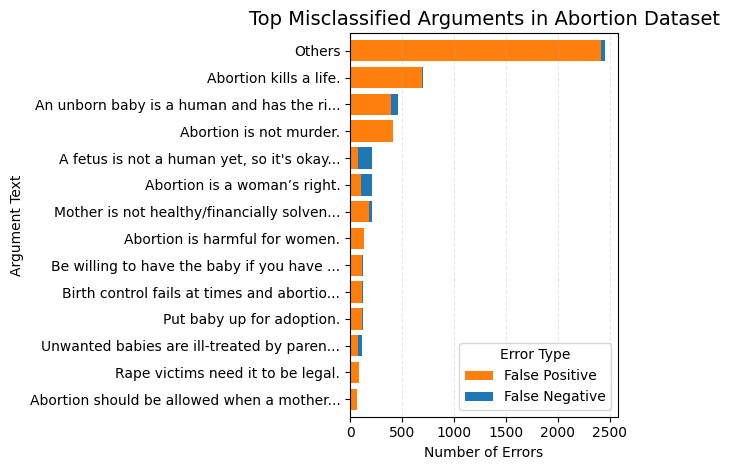

<Figure size 1000x600 with 0 Axes>

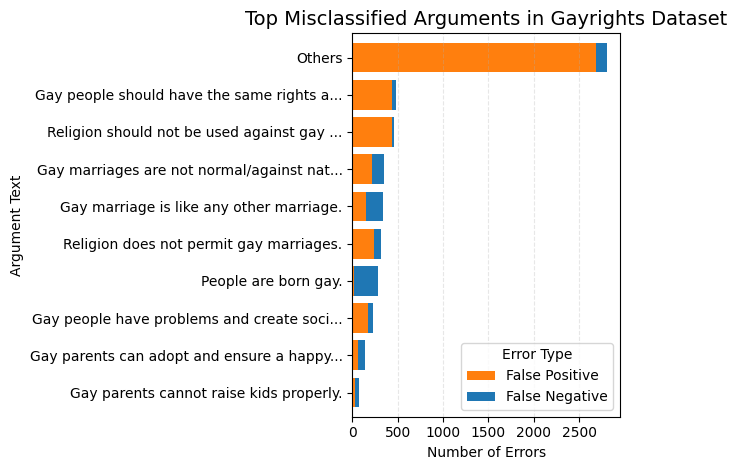

<Figure size 1000x600 with 0 Axes>

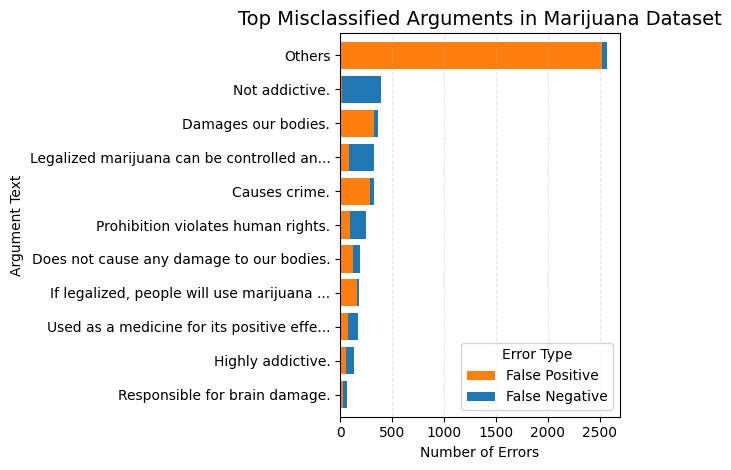

<Figure size 1000x600 with 0 Axes>

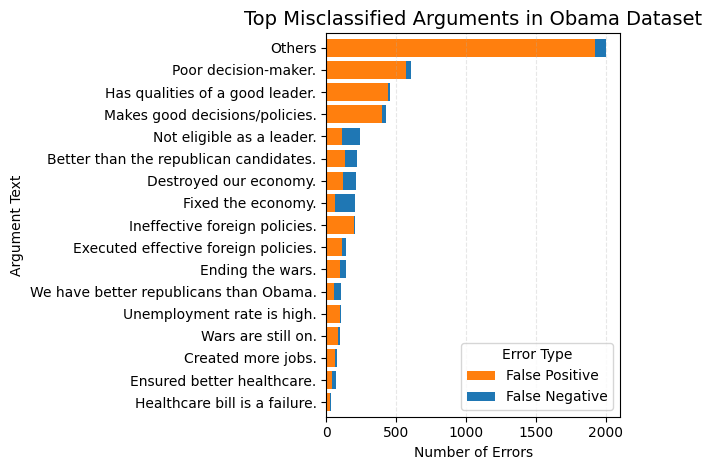

In [66]:
datasets = error_yru['dataset'].unique()

for dataset in datasets:
    dataset_df = error_yru[error_yru['dataset'] == dataset]

    top_arguments = dataset_df['argument'].value_counts().index
    
    plot_data = dataset_df[dataset_df['argument'].isin(top_arguments)]
    
    error_counts = plot_data.pivot_table(
        index='argument',
        columns='error_type',
        aggfunc='size',
        fill_value=0
    )
    
    error_counts['total'] = error_counts.sum(axis=1)
    error_counts = error_counts.sort_values('total', ascending=True)  
    
    # Plot
    plt.figure(figsize=(10, 6))
    ax = error_counts[['FP', 'FN']].plot(
        kind='barh',
        stacked=True,
        color=['#ff7f0e', '#1f77b4'],
        width=0.8
    )
    
    plt.title(f'Top Misclassified Arguments in {dataset.capitalize()} Dataset', fontsize=14)
    plt.xlabel('Number of Errors')
    plt.ylabel('Argument Text')
    plt.legend(title='Error Type', labels=['False Positive', 'False Negative'])
    
    ax.set_yticklabels([text[:40]+'...' if len(text)>40 else text 
                       for text in error_counts.index])
    
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

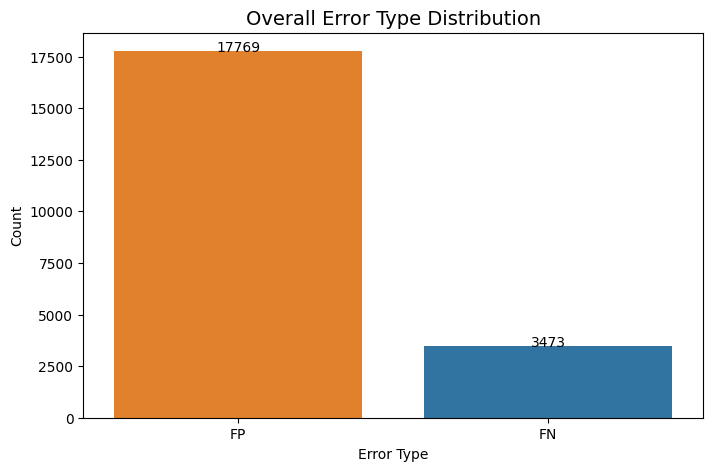

In [17]:
error_counts = error_yru['error_type'].value_counts()

# Create plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=error_counts.index, y=error_counts.values, palette=['#ff7f0e', '#1f77b4'])

plt.title('Overall Error Type Distribution', fontsize=14)
plt.xlabel('Error Type')
plt.ylabel('Count')

# Add value labels
for i, v in enumerate(error_counts.values):
    ax.text(i, v + 5, str(v), ha='center')

plt.show()

<Figure size 1000x600 with 0 Axes>

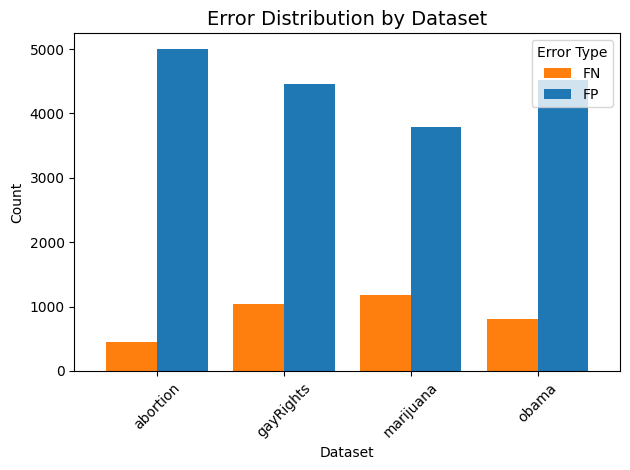

In [18]:
dataset_errors = error_yru.groupby(['dataset', 'error_type']).size().unstack()

# Create plot
plt.figure(figsize=(10, 6))
dataset_errors.plot(kind='bar', stacked=False, color=['#ff7f0e', '#1f77b4'], width=0.8)

plt.title('Error Distribution by Dataset', fontsize=14)
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Error Type')

plt.tight_layout()
plt.show()

## COMBINED

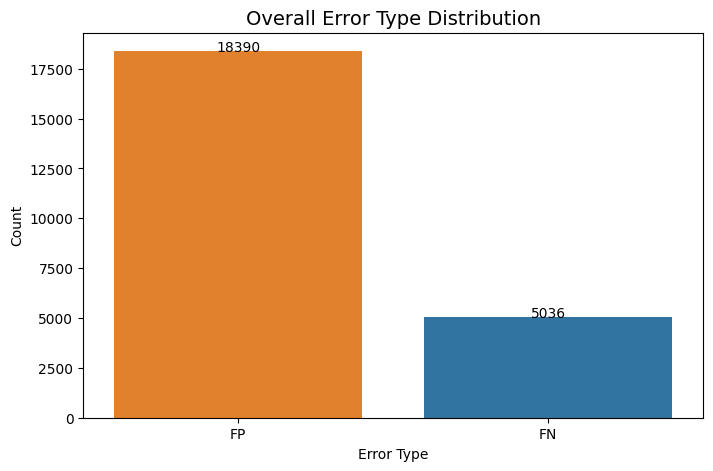

In [100]:
error_both = pd.concat([error_comarg, error_yru], ignore_index=True)

error_counts = error_both['error_type'].value_counts()

# Create plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=error_counts.index, y=error_counts.values, palette=['#ff7f0e', '#1f77b4'])

plt.title('Overall Error Type Distribution', fontsize=14)
plt.xlabel('Error Type')
plt.ylabel('Count')

# Add value labels
for i, v in enumerate(error_counts.values):
    ax.text(i, v + 5, str(v), ha='center')

plt.show()

<Figure size 1000x600 with 0 Axes>

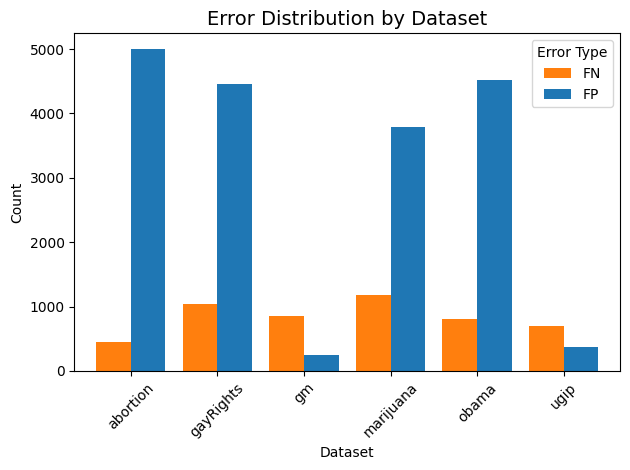

In [31]:
dataset_errors = error_both.groupby(['dataset', 'error_type']).size().unstack()

# Create plot
plt.figure(figsize=(10, 6))
dataset_errors.plot(kind='bar', stacked=False, color=['#ff7f0e', '#1f77b4'], width=0.8)

plt.title('Error Distribution by Dataset', fontsize=14)
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Error Type')

plt.tight_layout()
plt.show()

In [ ]:
def analyze_errors_by_topic(error_both):
    results = {}
    for topic in error_both['dataset'].unique():
        topic_df = error_both[error_both['dataset'] == topic]
        
        fp_count = len(topic_df[topic_df['error_type'] == 'FP'])
        fn_count = len(topic_df[topic_df['error_type'] == 'FN'])
        
        fp_samples = topic_df[topic_df['error_type'] == 'FP'].sample(min(10, fp_count))
        fn_samples = topic_df[topic_df['error_type'] == 'FN'].sample(min(10, fn_count))
        
        results[topic] = {
            'FP_count': fp_count,
            'FN_count': fn_count,
            'FP_examples': fp_samples[['argument', 'comment']].to_dict('records'),
            'FN_examples': fn_samples[['argument', 'comment']].to_dict('records')
        }
    return results
combined_errors_by_topic = analyze_errors_by_topic(error_both)

In [69]:
with open('error_analysis_by_topic.json', 'w') as f:
    json.dump(combined_errors_by_topic, f, indent=4)

In [80]:
def analyze_errors_by_topic(error_both):
    results = {}
    for topic in error_both['dataset'].unique():
        topic_df = error_both[error_both['dataset'] == topic]
        
        # Basic stats
        fp_count = len(topic_df[topic_df['error_type'] == 'FP'])
        fn_count = len(topic_df[topic_df['error_type'] == 'FN'])
        
        # Count misclassifications by argument
        fp_df = topic_df[topic_df['error_type'] == 'FP']
        fn_df = topic_df[topic_df['error_type'] == 'FN']
        
        argument_fp_counts = fp_df['argument'].value_counts().to_dict()
        argument_fn_counts = fn_df['argument'].value_counts().to_dict()
        
        # Sort arguments by frequency of misclassification
        fp_args_sorted = sorted(argument_fp_counts.items(), key=lambda x: x[1], reverse=True)
        fn_args_sorted = sorted(argument_fn_counts.items(), key=lambda x: x[1], reverse=True)
        
        # Prepare examples for each top argument
        fp_args_with_examples = []
        for arg, count in fp_args_sorted:
            arg_examples = fp_df[fp_df['argument'] == arg].head(5)[['argument', 'comment']].to_dict('records')
            full_text = topic_label_to_argument.get(topic, {}).get(arg, arg)
            fp_args_with_examples.append({
                'arg_code': arg,
                'count': count,
                'full_text': full_text,
                'examples': arg_examples
            })
        
        fn_args_with_examples = []
        for arg, count in fn_args_sorted:
            arg_examples = fn_df[fn_df['argument'] == arg].head(5)[['argument', 'comment']].to_dict('records')
            full_text = topic_label_to_argument.get(topic, {}).get(arg, arg)
            fn_args_with_examples.append({
                'arg_code': arg,
                'count': count,
                'full_text': full_text,
                'examples': arg_examples
            })
        
        results[topic] = {
            'FP_count': fp_count,
            'FN_count': fn_count,
            'most_common_FP_args': fp_args_with_examples,
            'most_common_FN_args': fn_args_with_examples
        }
    return results

combined_errors_by_topic = analyze_errors_by_topic(error_both)

for topic, analysis in combined_errors_by_topic.items():
    print(f"\n\n=== {topic.upper()} ANALYSIS ===")
    print(f"Total FP errors: {analysis['FP_count']}")
    print(f"Total FN errors: {analysis['FN_count']}")
    
    print("\n--- TOP MISCLASSIFIED ARGUMENTS (FALSE POSITIVES) ---")
    for i, arg_data in enumerate(analysis['most_common_FP_args'][:3]):  # Top 3 arguments
        if arg_data['arg_code'] != "p-Other" or arg_data['arg_code'] != "c-Other":
            print(f"\n{i+1}. {arg_data['arg_code']} ({arg_data['count']} errors)")
            print(f"   Full: {arg_data['full_text']}")
            print("   Examples:")
            for j, example in enumerate(arg_data['examples'][:3]):  # Show only 3 examples to keep output manageable
                print(f"     {j+1}. {example['comment']}")
    
    print("\n--- TOP MISCLASSIFIED ARGUMENTS (FALSE NEGATIVES) ---")
    for i, arg_data in enumerate(analysis['most_common_FN_args'][:3]):
        if arg_data['arg_code'] != "p-Other" or arg_data['arg_code'] != "c-Other":# Top 3 arguments
            print(f"\n{i+1}. {arg_data['arg_code']} ({arg_data['count']} errors)")
            print(f"   Full: {arg_data['full_text']}")
            print("   Examples:")
            for j, example in enumerate(arg_data['examples'][:3]):  # Show only 3 examples to keep output manageable
                print(f"     {j+1}. {example['comment']}")



=== GM ANALYSIS ===
Total FP errors: 254
Total FN errors: 861

--- TOP MISCLASSIFIED ARGUMENTS (FALSE POSITIVES) ---

1. Gay couples should be able to take advantage of the fiscal and legal benefits of marriage (100 errors)
   Full: Gay couples should be able to take advantage of the fiscal and legal benefits of marriage
   Examples:
     1. There isn't a lot of evidence to support the cons opinions. It's mostly just a collaboration of it's wrong., it's not natural. and the Bible says so. If those people spent half as much time arguing something that doesn't affect them into something useful, the world would be a much better place. If your God created these homosexual people, then why did he make them so wrong? Marriage is a LEGAL contract that everyone should have a right to. And if you don't believe that then you simply can't call yourself an American.
     2. I am a homosexual and honestly LOVE IS LOVE and why can't I live with my girlfriend ? So why can't I have a little paper th

In [79]:
with open('combined_errors_by_topic.json', 'w') as f:
    json.dump(combined_errors_by_topic, f, indent=4)

In [ ]:
e

In [103]:
def get_full_stance_distribution():
    all_stances = []
    for dataset in ["gm", "ugip"]:
        data_path = f'/Users/guida/llm_argument_tasks/clean_data/{dataset.upper()}.xml'
        data = xmltodict.parse(open(data_path).read())
        for unit in data['document']['unit']:
            stance = unit['argument']['stance']
            all_stances.append(stance)
    return pd.Series(all_stances).value_counts()

true_stance_dist = get_full_stance_distribution()
print(true_stance_dist)

Con    1240
Pro    1058
Name: count, dtype: int64


In [104]:
def get_yru_stance_distribution():
    all_stances = []
    for topic in ["abortion", "gayRights", "marijuana", "obama"]:
        df = pd.read_csv(f'task1_yru_gold/yru_{topic}_with_negatives_main.csv')
        for label in df['label']:
            if label.startswith("p-"):
                all_stances.append("Pro")
            elif label.startswith("c-"):
                all_stances.append("Con")
    return pd.Series(all_stances).value_counts()

true_yru_stances = get_yru_stance_distribution()
print(true_yru_stances)

Pro    13662
Con    11796
Name: count, dtype: int64


In [105]:
true_combined_stances = true_stance_dist.add(true_yru_stances, fill_value=0).astype(int)
print(true_combined_stances)


Con    13036
Pro    14720
Name: count, dtype: int64


## COMBINE BOTH DATASETS AND RETRIEVE CORRECT INSTANCES TOO

In [106]:
def evaluate_all_splits_with_errors():
    results = []
    error_cases = []
    correct_cases = []
    base_path = "comarg-task1"

    for model in ["gemini"]:
        dataset_results = []
        print(f"\n===== {model} =====")

        for dataset in ["gm", "ugip"]:  
            for split in range(1, 6): 
                for shot in ["5"]:
                    kshot_examples = get_kshot_examples(dataset, shot, split)
                    gold_raw = get_gold(binarize=False, task=1, data=dataset, kshot_examples=kshot_examples)
                    pred_file = f"comarg_{dataset}_identification_{model}_{shot}shot_split_{split}.jsonl"
                    pred_path = os.path.join(base_path, model, f"Split{split}", f"{shot}-s", pred_file)

                    try:
                        gold, pred, ids = get_predictions(pred_path, gold_raw)
                        labels = np.unique(np.concatenate([gold, pred]))

                        pr, re, f1, supp, cm = evaluate(gold, pred)
                        result = {
                            'dataset': dataset,
                            'model': model,
                            'split': split,
                            'shot': shot,
                            'precision': pr,
                            'recall': re,
                            'f1': f1,
                            'support': supp,
                            'confusion_matrix': cm
                        }
                        results.append(result)
                        dataset_results.append(result)

                        for g, p, id_ in zip(gold, pred, ids):
                            context = get_full_argument_context(dataset, id_)
                            entry = {
                                'dataset': dataset,
                                'split': split,
                                'id': id_,
                                'gold': g,
                                'pred': p,
                                'argument': context['argument'],
                                'stance': context['stance'],
                                'comment': context['comment']
                            }

                            if g != p:
                                entry['error_type'] = 'FP' if p == 1 and g == 0 else 'FN'
                                error_cases.append(entry)
                            else:
                                entry['error_type'] = 'correct'
                                correct_cases.append(entry)

                    except FileNotFoundError:
                        print(f"Missing file: {pred_path}")
                    except Exception as e:
                        print(f"Error processing {pred_path}: {str(e)}")

        print(f"\n{'='*20} Aggregate Results for {model} {'='*20}")
        dataset_df = pd.DataFrame(dataset_results)

        agg_results = dataset_df.groupby(['model', 'shot']).agg({
            'precision': ['mean', 'std'],
            'recall': ['mean', 'std'],
            'f1': ['mean', 'std']
        }).round(3)
        
        print(agg_results)

    return agg_results, pd.DataFrame(error_cases), pd.DataFrame(correct_cases)

def evaluate_all_splits_with_errors_yru():
    error_cases = []
    correct_cases = []
    base_path = "task1_yru_fewshot"
    topics = ["abortion", "gayRights", "marijuana", "obama"]

    for dataset in topics:
        for split in (1, 3, 4, 5):
            for shot in ["5"]:
                shot_examples = get_shot_examples(dataset, shot, split)
                gold_raw = get_yru_gold(task=dataset, shot=shot, split=split)
                pred_file = f"yru_{dataset}_identification_gemini_{shot}shot_split_{split}.jsonl"
                pred_path = os.path.join(base_path, "gemini", f"Split{split}", f"{shot}-s", pred_file)

                try:
                    gold_labels, pred_labels, ids = get_predictions(pred_path, gold_raw)
                    
                    for uid, gold, pred in zip(ids, gold_labels, pred_labels):
                        context = get_yru_full_context(dataset, uid)
                        entry = {
                            'dataset': dataset,
                            'split': split,
                            'id': uid,
                            'gold': gold,
                            'pred': pred,
                            'argument': context['argument'],
                            'stance': context['stance'],
                            'comment': context['comment']
                        }

                        if gold != pred:
                            entry['error_type'] = 'FP' if pred == 1 and gold == 0 else 'FN'
                            error_cases.append(entry)
                        else:
                            entry['error_type'] = 'correct'
                            correct_cases.append(entry)

                except Exception as e:
                    print(f"Error processing {pred_path}: {str(e)}")

    return pd.DataFrame(error_cases), pd.DataFrame(correct_cases)

agg_results, error_comarg, correct_comarg = evaluate_all_splits_with_errors()
error_yru, correct_yru = evaluate_all_splits_with_errors_yru()

error_all = pd.concat([error_comarg, error_yru], ignore_index=True)
correct_all = pd.concat([correct_comarg, correct_yru], ignore_index=True)

all_cases = pd.concat([correct_all, error_all], ignore_index=True)



===== gemini =====

==================== Aggregate Results for gemini ====================
            precision        recall            f1       
                 mean    std   mean    std   mean    std
model  shot                                             
gemini 5        0.795  0.041  0.748  0.027  0.771  0.033


In [107]:
correct_all.to_csv("correct_all.csv", index=False)
all_cases.to_csv("error_and_correct_both_data.csv", index=False)

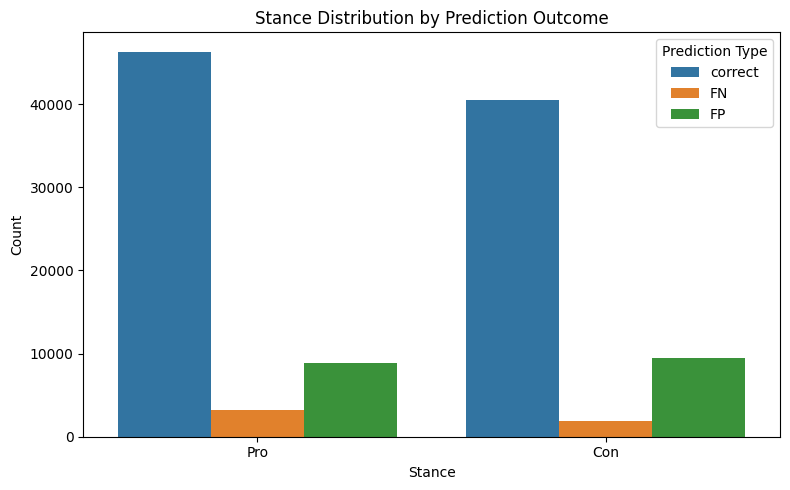

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=all_cases, x='stance', hue='error_type', order=['Pro', 'Con'])
plt.title("Stance Distribution by Prediction Outcome")
plt.xlabel("Stance")
plt.ylabel("Count")
plt.legend(title='Prediction Type')
plt.tight_layout()
plt.show()

In [118]:
all_cases

,dataset,split,id,gold,pred,argument,stance,comment,error_type
0,gm,1,74arg1,0,0,Gay couples can declare their union without resort to marriage,Con,I think that gay marriage should be allowed in every part of the world. If two people love eachother and want to be together forever then that sho...,correct
1,gm,1,163arg4,0,0,It is discriminatory to refuse gay couples the right to marry,Pro,"Unless... two gay people can create a life, which is why we are here as two opposing sexes. According to the gays, there should be one sex here on...",correct
2,gm,1,113arg4,0,0,It is discriminatory to refuse gay couples the right to marry,Pro,"Marriage:Men and women of full age, without any limitation due to race, nationality or religion, have the right to marry and to found a family. Th...",correct
3,gm,1,88arg5,1,1,Major world religions are against gay marriages,Con,"Immorality should never has A SAY,should never be accepted as something normal .Marriage is between a man and a woman not between 2 men or 2 wome...",correct
4,gm,1,77arg7,0,0,Marriage should be between a man and a woman,Con,"I'm con actually not because I think government shouldn't allow it, but I think government should be out of marriage, period. I believe it is imm...",correct
...,...,...,...,...,...,...,...,...,...
110262,obama,5,oba64arg8,0,1,Others,Pro,"When a leader makes promises and fails to keep them, he should not be reelected. Obama claimed that if he failed to turn the economy around by the...",FP
110263,obama,5,oba369arg17,0,1,Others,Con,"The first article is not false? Why then, why I search the authors name in Google, do I see, on the first page, two articles specifically stating ...",FP
110264,obama,5,oba294arg8,1,0,Others,Pro,"I can say the same thing about point 5 in your list. Anyway, it doesn't negate the general point that Obama is a busier president. And that the ...",FN
110265,obama,5,oba265arg13,0,1,Poor decision-maker.,Con,Thinking of the election that was placed you either had to choose from a very old republican canadiate who pretty much followed the steps of bush ...,FP


## With Metrics